Se debe agregar la carpeta a analizar en el drive y acceder a la carpeta compartida a través de las siguientes líneas.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Constantes

Recuerda que debes cambiar las constantes a como tu lo necesites. (Si cambia el path de directorio o imagen a probar)

In [2]:
# Directorio a analizar
in_dir = '/content/drive/MyDrive/Datos - Hackathon JusticIA/Evaluacion/Reto2'

In [3]:
# Alguna imagen en específico para analizar en la sección de una sola imagen
path = "/content/drive/MyDrive/Ficheros_Detenidos_Desaparecidos_Morales_Lopez_Delia_Morales_Lopez_Delia-23-.JPG"

In [4]:
# Directorio para guardar la salida del csv
output_dir_path = "/content/drive/MyDrive"

## Importación de librerias importantes

In [5]:
!pip install "git+https://github.com/caroacostatovany/hackathon_RIIAA2021.git#egg=busquedadesaparecidos&subdirectory=src" --quiet

     |████████████████████████████████| 45.6 MB 59 kB/s 
     |████████████████████████████████| 241 kB 43.7 MB/s 


In [6]:
author = 'caroacostatovany'
repository = 'hackathon_RIIAA2021'
!git clone https://github.com/{author}/{repository}.git

Cloning into 'hackathon_RIIAA2021'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (211/211), done.
remote: Total 300 (delta 163), reused 205 (delta 79), pack-reused 0
Receiving objects: 100% (300/300), 27.37 MiB | 16.29 MiB/s, done.
Resolving deltas: 100% (163/163), done.


In [7]:
!sudo apt install libleptonica-dev tesseract-ocr libtesseract-dev --quiet

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libleptonica-dev libtesseract-dev tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-osd
0 upgraded, 5 newly installed, 0 to remove and 40 not upgraded.
Need to get 7,550 kB of archives.
After this operation, 29.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libleptonica-dev amd64 1.75.3-3 [1,308 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libtesseract-dev amd64 4.00~git2288-10f4998a-2 [1,447 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/

In [8]:
!pip install -U spacy

     |████████████████████████████████| 5.8 MB 4.3 MB/s 
     |████████████████████████████████| 10.1 MB 34.4 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 621 kB 45.9 MB/s 
     |████████████████████████████████| 456 kB 54.1 MB/s 
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.0
    Uninstalling thinc-7.4.0:
      Successfully uninstalled thinc-7.4.0
  Attempting uninstall: spacy
    Found existing installation: spacy 2.2.4
    Uninstalling spacy-2.2.4:
      Successfully uninstalled spacy-2.2.4


In [9]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import timeit

Found GPU at: /device:GPU:0


In [10]:
%cd {repository}

/content/hackathon_RIIAA2021


In [11]:
import os
import cv2
import numpy as np
import pytesseract
import pandas as pd
import json


# Importamos el visualizador incluido en spacy
from spacy import displacy
from google.colab.patches import cv2_imshow
from PIL import Image
from skimage.transform import rotate
from skimage.io import imread
from skimage.color import rgb2gray

from busquedadesaparecidos.ocr.procesamiento_imagen import escala_grises, eliminar_ruido, skew_angle_hough_transform
from busquedadesaparecidos.utils.limpieza_texto import quitar_caracteres_especiales, quitar_nonascii, quitar_stopwords, convierte_minusculas, renombrar_clases_spacy
from busquedadesaparecidos.ner.busqueda_expediente import encontrar_expediente, convertir_texto_exp_dataframe
from busquedadesaparecidos.ner.spacy import obtener_entidades, guardar_entidades_en_dataframe
from busquedadesaparecidos.ner.similar_words import TargetWords


# Importamos spacy y el modelo en español
import spacy
nlp = spacy.load("es_core_news_lg")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_lg')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Lectura de un directorio

In [ ]:
folder_list=os.listdir(in_dir)

reto_2b_mayus = pd.DataFrame()
reto_2b_minus = pd.DataFrame()
reto_2a = pd.DataFrame() 
df_target_words_gral = pd.DataFrame()

for folders, sub_folders, file in os.walk(in_dir):
    for name in file:
        # Buscamos los formatos que terminan en png, jpg, jpeg dentro del directorio
        if name.lower().endswith((".jpg",".png",".jpeg")):
          path = "{}/{}".format(in_dir, name)
          print("="*100)
          print("Analizando archivo {}".format(path))
          file_name, file_extension = os.path.splitext(path)
          print("Iniciando procesamiento de imagen")
          # Leemos la imagen
          image = rgb2gray(imread(path))
          print("Revisando si la imagen necesita rotación")
          # Utilizamos hough lines por si necesitamos rotación
          image_rotate = rotate(image, skew_angle_hough_transform(image), cval=1)
          image = cv2.normalize(src= image_rotate, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
          im_rotada = Image.fromarray(image)
          # Se guarda temporalmente en un archivo
          im_rotada.save('rotada{}'.format(file_extension))
          imagen_rotada = cv2.imread('rotada{}'.format(file_extension))

          # Iniciamos con la eliminación de ruido
          gray_img = escala_grises(imagen_rotada)
          imagen_sin_ruido = eliminar_ruido(gray_img)

          im = Image.fromarray(imagen_sin_ruido)
          save_path = "gray{}".format(file_extension)
          im.save(save_path)

          # utilizamos la paquetería de binarize
          !python binarize/binarize.py -imgpath "{save_path}" -save out_test"{file_extension}"
          
          img = cv2.imread('out_test{}'.format(file_extension))
          kernel = np.ones((2, 2),np.uint8)
          closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
          dilation = cv2.erode(closing, kernel,iterations = 1)
          print("Procesamiento de imagen terminada")

          print("Iniciando OCR")
          # Utilizamos pytesseract para obtener el texto de la imagen
          texto_extraido = pytesseract.image_to_string(dilation)
          print("OCR terminado")


          if texto_extraido is None:
            print("No se encontró texto en {}".format(path))
          else:
            print("Iniciando análisis de similitudes")
            # Se buscan similitudes 
            tw_prosecuted = TargetWords(texto_extraido, 'prosecuted')
            tw_organization = TargetWords(texto_extraido, 'organization')
            tw_states = TargetWords(texto_extraido, 'state')

            json_prosecuted = json.dumps(tw_prosecuted.results)
            json_organization = json.dumps(tw_organization.results)
            json_states = json.dumps(tw_states.results)

            df_target_words = pd.DataFrame([(json_prosecuted, json_organization, json_states, path)], 
                                           columns=['personas', 'organizaciones', 'estados', 'filename'])
            
            df_target_words_gral = pd.concat([df_target_words_gral, df_target_words])


            print("Iniciando limpieza de texto")
            # Se limpia
            texto_limpio = quitar_caracteres_especiales(texto_extraido)
            texto_limpio = quitar_nonascii(texto_limpio)
            texto_limpio = quitar_stopwords(texto_limpio)
            texto_limpio_minusculas = convierte_minusculas(texto_limpio)
            print("Limpieza de texto terminada")
            print("Iniciando búsqueda de expediente")
            exp = encontrar_expediente(texto_limpio_minusculas)
            print(exp)
            df_exp = convertir_texto_exp_dataframe(path, exp, texto_limpio_minusculas)
            reto_2a = pd.concat([reto_2a, df_exp])
            print("Búsqueda de expediente finalizada")
            
            print("Iniciando clasificación de entidades")
            #doc_mayus = obtener_entidades(texto_limpio)
            #df_mayus = guardar_entidades_en_dataframe(doc_mayus, path)
            #reto_2b_mayus = pd.concat([reto_2b_mayus, df_mayus])

            doc_minus = obtener_entidades(texto_limpio_minusculas)
            df_minus = guardar_entidades_en_dataframe(doc_minus, path)
            reto_2b_minus = pd.concat([reto_2b_minus, df_minus])
            print("Clasificación de entidades finalizada")


#reto_2b_mayus = renombrar_clases_spacy(reto_2b_mayus)
reto_2b_minus = renombrar_clases_spacy(reto_2b_minus)

reto_2a.to_csv("{}/reto_2a.csv".format(output_dir_path))
#reto_2b_mayus.to_csv("{}/reto_2b_mayus.csv".format(output_dir_path))
reto_2b_minus.to_csv("{}/reto_2b.csv".format(output_dir_path))
df_target_words_gral.to_csv('{}/similitud.csv'.format(output_dir_path))


Analizando archivo /content/drive/MyDrive/Datos - Hackathon JusticIA/Evaluacion/Reto2/Ficheros_ACNR_militantes_Olea_Castaneyra_Rafel_Olea_Castaneyra_Rafael,_ACNR-19-.JPG
Iniciando procesamiento de imagen
Revisando si la imagen necesita rotación
[-0.61858396]
2021-08-23 14:44:37.117434: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 14:44:37.129287: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 14:44:37.130099: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 14:44:37.617579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.c



---

Aquí termina lectura de directorio

---



# Lectura de una imagen (sin guardar output en csv)

In [12]:
# Leemos la imagen
image = rgb2gray(imread(path))

In [13]:
file_name, file_extension = os.path.splitext(path)

# Procesamiento de imagen

## Rotación de imagen si es necesaria

In [14]:
#image_rotate vareable
image_rotate = rotate(image, skew_angle_hough_transform(image), cval=1)
image = cv2.normalize(src= image_rotate, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
im_rotada = Image.fromarray(image)
im_rotada.save('rotada{}'.format(file_extension))

[-0.04562616]




---



---



In [15]:
imagen_rotada = cv2.imread('rotada{}'.format(file_extension))

gray_img = escala_grises(imagen_rotada)
imagen_sin_ruido = eliminar_ruido(gray_img)

In [16]:
im = Image.fromarray(imagen_sin_ruido)
save_path = "gray{}".format(file_extension)
im.save(save_path)

In [17]:
!python binarize/binarize.py -imgpath "{save_path}" -save out_test"{file_extension}"

2021-08-23 18:00:58.816755: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 18:00:58.837315: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 18:00:58.838159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 18:00:59.303033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-23 18:00:59.303823: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [18]:
img = cv2.imread('out_test{}'.format(file_extension))

In [19]:
kernel = np.ones((2, 2),np.uint8)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

In [20]:
dilation = cv2.erode(closing, kernel,iterations = 1)

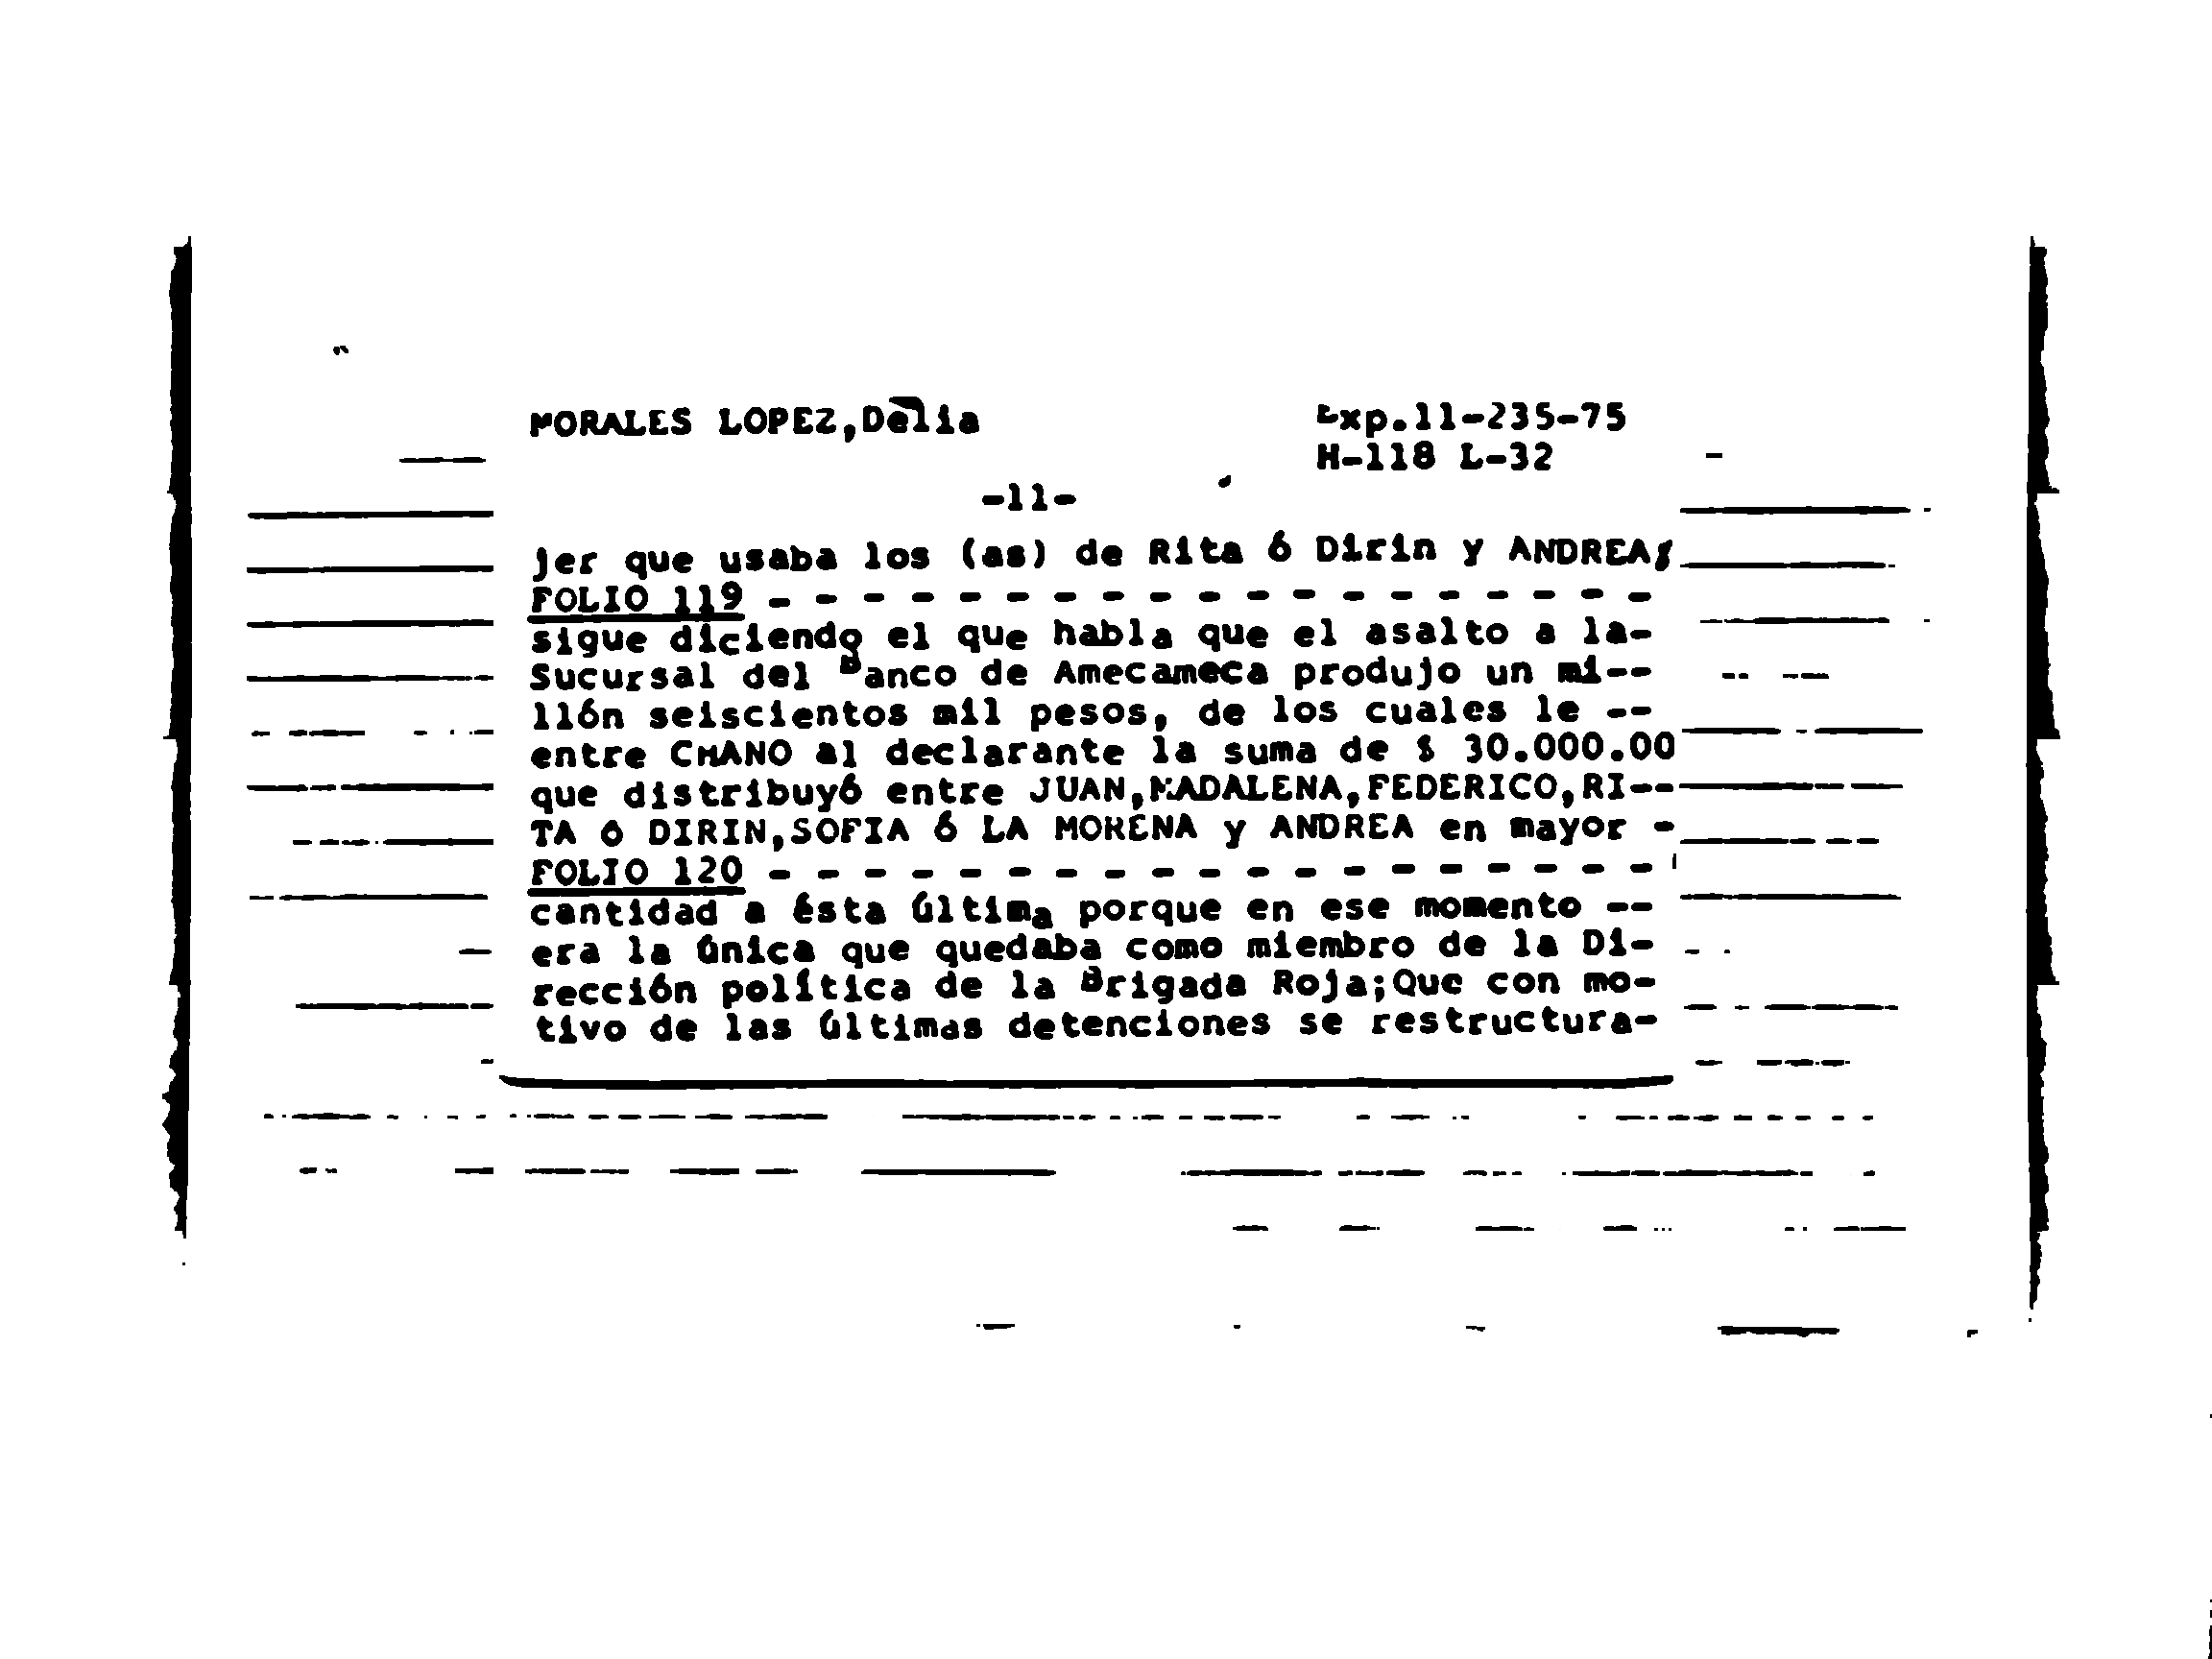

In [21]:
cv2_imshow(dilation)

# OCR 

In [22]:
texto_extraido = pytesseract.image_to_string(dilation)

In [23]:
texto_extraido

'MORALES LOPEZ,Délia &xp.ll-235-75\nH-118 L-32 -\nwlle ‘\n\njer que usaba los (as) de Rita 6 Dirin y ANDREAS\nFOLIO GQeeereeexrexeereeereereerr er er ee\nsigue diciendg el que habla que el asalto a la-\nSucursal de} Banco de Amecameca produjo un mi-= 9 -- -—\nllén seiscientos mil pesos, de los cuales le --\nentre CHANO a] declarante la suma de $ 30.000.00\nque distribuy$ entre JUAN,MADALENA, FEDERICO, RI--\nTA © DIRIN,SOFIA & LA MORENA y ANDREA en mayor =\nFOLIO 120 + ------- ee ee eee eee!\ncantidad a ésta Gitima porque en ese momento --\nera la Gnica que quedaba como miembro de la Die -_.\nreccién politica de la Srigada Roja;Que con moe\ntivo de las Gitimas detenciones se restructura-\n\n \n\n \n\x0c'

In [24]:
tw_prosecuted = TargetWords(texto_extraido, 'prosecuted')
tw_organization = TargetWords(texto_extraido, 'organization')
tw_states = TargetWords(texto_extraido, 'state')

In [25]:
json_prosecuted = json.dumps(tw_prosecuted.results)
json_organization = json.dumps(tw_organization.results)
json_states = json.dumps(tw_states.results)

In [26]:
df_target_words = pd.DataFrame([(json_prosecuted, json_organization, json_states, path)], columns=['personas', 'organizaciones', 'estados', 'filename'])
df_target_words

,personas,organizaciones,estados,filename
0,"[[1.0, ""juan morales"", [""Juan"", ""Morales""]], [...","[[0.86, ""momento"", [""Momento""]]]",null,/content/drive/MyDrive/Ficheros_Detenidos_Desa...


# Limpieza de texto

In [27]:
texto_limpio = quitar_caracteres_especiales(texto_extraido)
texto_limpio = quitar_nonascii(texto_limpio)
texto_limpio = quitar_stopwords(texto_limpio)

In [28]:
texto_limpio

'MORALES LOPEZDelia & xpll-235-75H-118 L-32 -wlle jer usaba as Rita 6 Dirin y ANDREASFOLIO GQeeereeexrexeereeereereerr er er eesigue diciendg habla asalto la-Sucursal } Banco Amecameca produjo un mi- 9 -- -llen seiscientos mil pesos cuales le -- entre CHANO ] declarante suma $ 3000000que distribuy $ entre JUANMADALENA FEDERICO RI -- TA DIRINSOFIA & LA MORENA y ANDREA mayor FOLIO 120 + -- -- -- - ee ee eee eeecantidad esta Gitima porque ese momento -- era Gnica quedaba como miembro Die -reccien politica Srigada RojaQue con moetivo Gitimas detenciones restructura-'

In [29]:
texto_limpio_minusculas = convierte_minusculas(texto_limpio)

In [30]:
texto_limpio_minusculas

'morales lopezdelia & xpll-235-75h-118 l-32 -wlle jer usaba as rita 6 dirin y andreasfolio gqeeereeexrexeereeereereerr er er eesigue diciendg habla asalto la-sucursal } banco amecameca produjo un mi- 9 -- -llen seiscientos mil pesos cuales le -- entre chano ] declarante suma $ 3000000que distribuy $ entre juanmadalena federico ri -- ta dirinsofia & la morena y andrea mayor folio 120 + -- -- -- - ee ee eee eeecantidad esta gitima porque ese momento -- era gnica quedaba como miembro die -reccien politica srigada rojaque con moetivo gitimas detenciones restructura-'

# EXP

In [31]:
x = encontrar_expediente(texto_limpio_minusculas)

In [32]:
df_exp = convertir_texto_exp_dataframe(path, x, texto_limpio_minusculas)

In [33]:
df_exp

,filename,text
0,/content/drive/MyDrive/Ficheros_Detenidos_Desa...,No encontrado| morales lopezdelia & xpll-235-7...


# NER

## Texto utilizando mayus

In [34]:
doc = obtener_entidades(texto_limpio)

In [35]:
# Se muestran las entidades con el visualizador
for sent in doc.sents:
    displacy.render(nlp(sent.text),style='ent',jupyter=True)

In [36]:
# Se extraen las entidades con su tipo
df_mayus = guardar_entidades_en_dataframe(doc, path)
df_mayus = renombrar_clases_spacy(df_mayus)

In [37]:
df_mayus

,texto,clase,filename
0,LOPEZDelia,otro,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
1,L-32,organizacion,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
2,as Rita 6 Dirin,lugar,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
3,ANDREASFOLIO GQeeereeexrexeereeereereerr er er...,otro,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
4,la-Sucursal,otro,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
5,Banco Amecameca,lugar,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
6,CHANO,lugar,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
7,JUANMADALENA,otro,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
8,TA DIRINSOFIA & LA MORENA,organizacion,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
9,ANDREA,organizacion,/content/drive/MyDrive/Ficheros_Detenidos_Desa...


## Texto todo en minusculas

In [38]:
doc = obtener_entidades(texto_limpio_minusculas)

In [39]:
# Se muestran las entidades con el visualizador
for sent in doc.sents:
    displacy.render(nlp(sent.text),style='ent',jupyter=True)

In [40]:
# Se extraen las entidades con su tipo
df_minus = guardar_entidades_en_dataframe(doc, path)

In [41]:
df_minus = renombrar_clases_spacy(df_minus)

In [42]:
df_minus

,texto,clase,filename
0,andreasfolio gqeeereeexrexeereeereereerr er er...,persona,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
1,juanmadalena federico ri -- ta dirinsofia & la...,persona,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
2,andrea mayor,persona,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
3,ee ee eee,lugar,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
4,die -reccien,otro,/content/drive/MyDrive/Ficheros_Detenidos_Desa...
